In [1]:
import torch

from Models.unetCCT import UNet
from Models.Transformer.SwinUnet import SwinUnet

def load_model(path):
    checkpoint = torch.load(path)
    model = UNet(in_chns=3, class_num=3)
    # model = SwinUnet(448, num_classes=3)
    

    # Print checkpoint keys to debug
    print(f"Available keys in checkpoint: {checkpoint.keys()}")
    try:
        model.load_state_dict(checkpoint['model_state_dict'])
    except KeyError:
        # Try loading without 'model_state_dict' key if checkpoint contains direct state dict
        model.load_state_dict(checkpoint)
    return model


# # Load models one at a time to identify which file causes issues
# try:
#     cps_best_model = load_model('./checkpoints/kvasir-seg/cps_0.125/fold5/best.pth')
# except Exception as e:
#     print(f"Error loading CPS model: {str(e)}")
#     cps_best_model = None

try:
    best_model = load_model('/home/student02/hieu/Projects/SSSS/checkpoints/fugc/fixmatch/fold4/best.pth')
except Exception as e:
    print(f"Error loading model: {str(e)}")
    best_model = None

# try:
#     ccvc_best_model = load_model('/home/m12gbs1/hieup/Project/SSSS/checkpoints/isic2018/ccvc_0.04/fold2/best.pth')
# except Exception as e:
#     print(f"Error loading CCVC model: {str(e)}")
#     ccvc_best_model = None

# try:
#     ccvc_newloss_best_model = load_model('/home/m12gbs1/hieup/Project/SSSS/checkpoints/isic2018/ccvc_newloss_0.04/fold2/best.pth')
# except Exception as e:
#     print(f"Error loading CCVC newloss model: {str(e)}")
#     ccvc_newloss_best_model = None
    



/home/student02/anaconda3/envs/semi/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/student02/anaconda3/envs/semi/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/student02/anaconda3/envs/semi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/student02/anaconda3/envs/semi/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.l

Available keys in checkpoint: odict_keys(['encoder.in_conv.conv_conv.0.weight', 'encoder.in_conv.conv_conv.0.bias', 'encoder.in_conv.conv_conv.1.weight', 'encoder.in_conv.conv_conv.1.bias', 'encoder.in_conv.conv_conv.1.running_mean', 'encoder.in_conv.conv_conv.1.running_var', 'encoder.in_conv.conv_conv.1.num_batches_tracked', 'encoder.in_conv.conv_conv.4.weight', 'encoder.in_conv.conv_conv.4.bias', 'encoder.in_conv.conv_conv.5.weight', 'encoder.in_conv.conv_conv.5.bias', 'encoder.in_conv.conv_conv.5.running_mean', 'encoder.in_conv.conv_conv.5.running_var', 'encoder.in_conv.conv_conv.5.num_batches_tracked', 'encoder.down1.maxpool_conv.1.conv_conv.0.weight', 'encoder.down1.maxpool_conv.1.conv_conv.0.bias', 'encoder.down1.maxpool_conv.1.conv_conv.1.weight', 'encoder.down1.maxpool_conv.1.conv_conv.1.bias', 'encoder.down1.maxpool_conv.1.conv_conv.1.running_mean', 'encoder.down1.maxpool_conv.1.conv_conv.1.running_var', 'encoder.down1.maxpool_conv.1.conv_conv.1.num_batches_tracked', 'encoder.

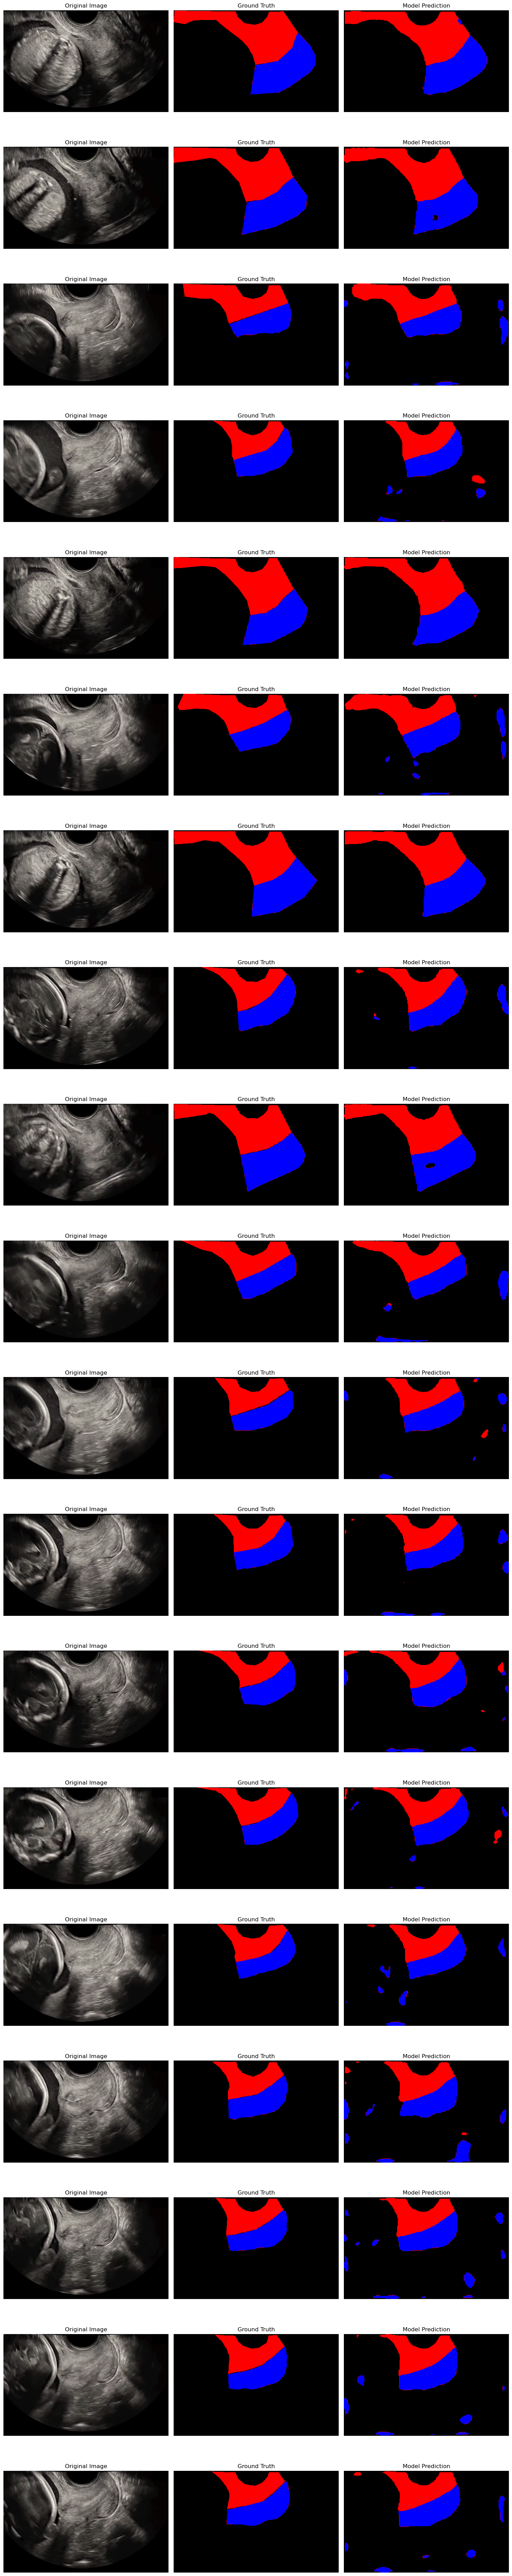

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch.nn.functional as F

def load_and_preprocess_image(image_path):
    """Load and preprocess image for model input"""
    # Load .npy file
    img = np.load(image_path)
    original_size = img.shape[:2]
    
    # Convert to tensor
    img = img / 255.0  # Normalize to [0,1]
    if len(img.shape) == 3:
        img = img.transpose(2, 0, 1)  # Change to CxHxW format
    img_tensor = torch.FloatTensor(img).unsqueeze(0)  # Add batch dimension
    
    # Resize to 512x512 using torch
    img_tensor = F.interpolate(img_tensor, size=(224, 224), mode='bilinear', align_corners=False)
    
    return img_tensor, original_size

def get_prediction(model, image, original_size):
    """Get prediction from model and resize back to original size"""
    if model is None:
        return None
    
    with torch.no_grad():
        pred = model(image)
        pred = torch.softmax(pred, dim=1)  # Use softmax for multi-class
        pred = pred.argmax(dim=1)  # Get class indices
        
        # Resize prediction back to original size using torch
        pred = pred.unsqueeze(1).float()  # Add channel dimension
        pred = F.interpolate(pred, size=original_size, mode='nearest')
        pred = pred.squeeze().cpu().numpy()
        
    return pred

def visualize_results(image_paths, gt_paths, save_path=None):
    """Visualize original images, ground truth and predictions from models"""
    num_images = len(image_paths)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 4*num_images))
    
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    # Define colormap for different classes
    colors = ['black', 'red', 'blue']  # Add more colors for more classes
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    
    for idx, (img_path, gt_path) in enumerate(zip(image_paths, gt_paths)):
        # Load and preprocess image
        image, original_size = load_and_preprocess_image(img_path)
        
        # Load original image and ground truth as numpy arrays
        original_img = np.load(img_path)
        gt = np.load(gt_path)
        
        # Get prediction from best model
        pred = get_prediction(best_model, image, original_size)
        
        # Plot results
        axes[idx, 0].imshow(original_img)
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(gt, cmap=cmap, vmin=0, vmax=len(colors)-1)
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')
        
        if pred is not None:
            axes[idx, 2].imshow(pred, cmap=cmap, vmin=0, vmax=len(colors)-1)
            axes[idx, 2].set_title('Model Prediction')
        else:
            axes[idx, 2].set_title('Model Not Loaded')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Example usage
image_paths = [
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0007.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0019.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0033.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0042.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0016.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0028.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0011.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0047.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0025.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0036.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0037.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0038.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0039.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0040.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0041.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0043.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0044.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0045.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/images/0046.npy',
]

gt_paths = [
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0007.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0019.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0033.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0042.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0016.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0028.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0011.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0047.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0025.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0036.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0037.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0038.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0039.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0040.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0041.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0043.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0044.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0045.npy',
    '/home/student02/hieu/Projects/SSSS/data_processed/fugc/train/labeled_data/labels/0046.npy',
]

visualize_results(image_paths, gt_paths, save_path='comparison_results_512.png')